### Compute Metric Example Workflow

In this notebook we showcase how a fictional T&E engineer, Jack, could utilize NRTK and the ImageMetric interface in a workflow.

Jack has identified that the quality of images his model will be receiving is likely to degrade due to a variety of natural pertubations beyond what was initially expected. He wants to use NRTK to explore the direct relationship between image quality and model performance.

In [1]:
%matplotlib inline
%config InlineBackend.figure_format = "jpeg"  # Use JPEG format for inline visualizations
from matplotlib import pyplot as plt  # type: ignore

import numpy as np
from pathlib import Path
from typing import Iterable, Hashable, Tuple, Dict, Any, Callable

from dataclasses import dataclass
import torch
from transformers import AutoModelForObjectDetection  # type: ignore
from transformers import AutoImageProcessor  # type: ignore
from torchvision.transforms.functional import get_image_size  # type: ignore
from torchmetrics.detection.mean_ap import MeanAveragePrecision

from maite.protocols import ArrayLike
from maite.protocols.object_detection import ObjectDetectionTarget
import maite.protocols.object_detection as od
from maite.workflows import evaluate

from smqtk_image_io.bbox import AxisAlignedBoundingBox
from smqtk_detection.impls.detect_image_objects.resnet_frcnn import ResNetFRCNN

from nrtk.impls.image_metric.snr_image_metric import SNRImageMetric
from nrtk.impls.score_detections.class_agnostic_pixelwise_iou_scorer import ClassAgnosticPixelwiseIoUScorer
from nrtk.impls.perturb_image.generic.skimage.random_noise import PepperNoisePerturber
from nrtk.impls.perturb_image.generic.cv2.blur import GaussianBlurPerturber
from nrtk.impls.perturb_image.generic.PIL.enhance import BrightnessPerturber

from nrtk_jatic.interop.object_detection.augmentation import JATICDetectionAugmentation, JATICDetectionAugmentationWithMetric
from nrtk_jatic.interop.object_detection.dataset import JATICObjectDetectionDataset
from models.datasets import VisDroneDataset

/home/local/KHQ/alexander.lynch/anaconda3/envs/nrtk-jatic/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
tm_metric = MeanAveragePrecision(
    box_format="xyxy",
    iou_type="bbox",
    iou_thresholds=[0.5],
    rec_thresholds=[0.0, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1.0],
    max_detection_thresholds=[1, 10, 100],
    class_metrics=False,
    extended_summary=False,
    average="macro"
)

class WrappedTorchmetricsMetric:
    def __init__(
        self,
        tm_metric: Callable[
            [list[dict[str, torch.Tensor]], list[dict[str, torch.Tensor]]], dict[str, Any]]
    ):
        self._tm_metric = tm_metric

    # Create utility function to convert ObjectDetectionTarget_impl type to what
    # the type expected by torchmetrics IntersectionOverUnion metric
    @staticmethod
    def to_tensor_dict(target: od.ObjectDetectionTarget) -> dict[str, torch.Tensor]:
        """
        Convert an ObjectDetectionTarget_impl into a dictionary expected internally by
        raw `update` method of raw torchmetrics method
        """
        out = {
            "boxes": torch.as_tensor(target.boxes),
            "scores": torch.as_tensor(target.scores),
            "labels": torch.as_tensor(target.labels),
        }

        return out

    def update(self, preds: od.TargetBatchType, targets: od.TargetBatchType) -> None:
        # Convert to natively-typed from of preds/targets
        preds_tm = [self.to_tensor_dict(pred) for pred in preds]
        targets_tm = [self.to_tensor_dict(tgt) for tgt in targets]
        self._tm_metric.update(preds_tm, targets_tm)

    def compute(self) -> dict[str, Any]:
        return self._tm_metric.compute()

    def reset(self) -> None:
        self._tm_metric.reset()

mAP_metric: od.Metric = WrappedTorchmetricsMetric(tm_metric)

In [3]:
@dataclass
class ObjectDetectionData:
    boxes: ArrayLike
    labels: ArrayLike
    scores: ArrayLike
    def __iter__(self):
        self.n = 0
        return self

    def __next__(self):
        if self.n < len(self.boxes):
            self.n += 1
            return self.boxes[self.n-1], self.labels[self.n-1], self.scores[self.n-1]
        else:
            raise StopIteration

def dets_to_maite(dets: Iterable[Tuple[AxisAlignedBoundingBox, Dict[Hashable, float]]],
                  thresh: float = 0.4) -> ObjectDetectionTarget:
    boxes = []
    labels = []

    for box, probs in dets:
        box_out = box.min_vertex.tolist()
        box_out.extend(box.max_vertex.tolist())

        # Just keep the highest scored prediction
        cls_name = max(probs, key=lambda key: probs[key])
        if probs[cls_name] > thresh:
            cls_idx = list(probs.keys()).index(cls_name)

            boxes.append(box_out)
            labels.append(cls_idx)

    return ObjectDetectionData(
        boxes=np.asarray(boxes, dtype=float),
        labels=np.asarray(labels, dtype=int),
        scores=np.asarray([1] * len(labels), dtype=int)
    )

DEMO_ROOT = Path.cwd().parent
basic_dataset = VisDroneDataset(DEMO_ROOT / "examples/data" / "VisDrone2019-DET-test-dev-TINY")
img_quality_metric = SNRImageMetric()

In [4]:
class HuggingFaceDetector:
    def __init__(self, model_name: str, threshold: float, device: str):
        self.image_processor = AutoImageProcessor.from_pretrained(model_name)
        self.model = AutoModelForObjectDetection.from_pretrained(model_name)
        self.threshold = threshold
        self.device = device

        self.model.eval()
        self.model.to(device)

    def id2label(self) -> Dict[int, Hashable]:
        return self.model.config.id2label

    def __call__(self, batch: od.InputBatchType) -> od.TargetBatchType:
        # tensor bridging
        input = torch.as_tensor(batch)
        assert input.ndim == 4

        # save original image sizes for resizing boxes
        target_sizes = [get_image_size(img)[::-1] for img in input]

        # preprocess
        hf_inputs = self.image_processor(input, return_tensors="pt")

        # put on device
        hf_inputs = hf_inputs.to(self.device)

        # get predictions
        with torch.no_grad():
            hf_predictions = self.model(**hf_inputs)
        hf_results = self.image_processor.post_process_object_detection(
            hf_predictions, 
            threshold=self.threshold, 
            target_sizes=target_sizes
        )

        predictions: od.TargetBatchType = list()
        for result in hf_results:
            predictions.append(
                ObjectDetectionData(
                    result["boxes"].detach().cpu(),
                    result["labels"].detach().cpu(),
                    result["scores"].detach().cpu()
                )
            )

        return predictions

model_name = "facebook/detr-resnet-50"
jatic_detector: od.Model = HuggingFaceDetector(
    model_name=model_name,
    threshold=0.5,
    device='cuda' if torch.cuda.is_available() else 'cpu'
)

Some weights of the model checkpoint at facebook/detr-resnet-50 were not used when initializing DetrForObjectDetection: ['model.backbone.conv_encoder.model.layer1.0.downsample.1.num_batches_tracked', 'model.backbone.conv_encoder.model.layer2.0.downsample.1.num_batches_tracked', 'model.backbone.conv_encoder.model.layer3.0.downsample.1.num_batches_tracked', 'model.backbone.conv_encoder.model.layer4.0.downsample.1.num_batches_tracked']
- This IS expected if you are initializing DetrForObjectDetection from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing DetrForObjectDetection from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


Jack wants to test a variety of pertubations on his maite compliant dataset.

After setting up NRTK generators for each perturber he will run the generators to get the model performance and compute the image quality metric to compare the performance against

In [6]:
import torch  # type: ignore
import random

random.seed(42)
np.random.seed(42)
torch.manual_seed(42)

img_quality_metrics = []
performance = []
for amount in [i*0.05 for i in range(15)]:
    perturber = PepperNoisePerturber(amount=amount)
    augmentation = JATICDetectionAugmentation(perturber)
    results, _, _ = evaluate(model=jatic_detector,
                          metric=mAP_metric,
                          dataset=basic_dataset,
                          augmentation=augmentation
                          )
    performance.append(results['map'])
    avg_quality = 0
    for batch in basic_dataset:
        aug_img, _, _ = augmentation([[component] for component in batch] )
        aug_img = np.transpose(aug_img[0], (1,2,0))
        avg_quality += img_quality_metric.compute(aug_img)
    img_quality_metrics.append(avg_quality/len(basic_dataset))


plt.cla()
plt.plot(img_quality_metrics, performance)
plt.title('Performance vs Image Quality metric as Gaussian Blur is applied')
plt.xlabel('Signal to Noise Ratio')
plt.ylabel('mean ClassAgnosticPixelwiseIoU')

KeyboardInterrupt: 

In [11]:
perturber = GaussianBlurPerturber(ksize=1)

augmentation = JATICDetectionAugmentation(perturber)
avg_quality = 0
for batch in basic_dataset:
    aug_img, _, _ = augmentation([[component] for component in batch] )
    print(aug_img[0].shape)
    aug_img = np.transpose(aug_img[0], (1,2,0))
    avg_quality += img_quality_metric.compute(aug_img)

img_quality_metrics.append(avg_quality/len(basic_dataset))

(3, 765, 1360)
(3, 765, 1360)
(3, 765, 1360)
(3, 765, 1360)
(3, 765, 1360)
(3, 765, 1360)
(3, 765, 1360)
(3, 765, 1360)
(3, 765, 1360)
(3, 765, 1360)
(3, 540, 960)


NameError: name 'img_quality_metrics' is not defined

100%|██████████| 15/15 [00:58<00:00,  3.93s/it]


Text(0, 0.5, 'mean ClassAgnosticPixelwiseIoU')

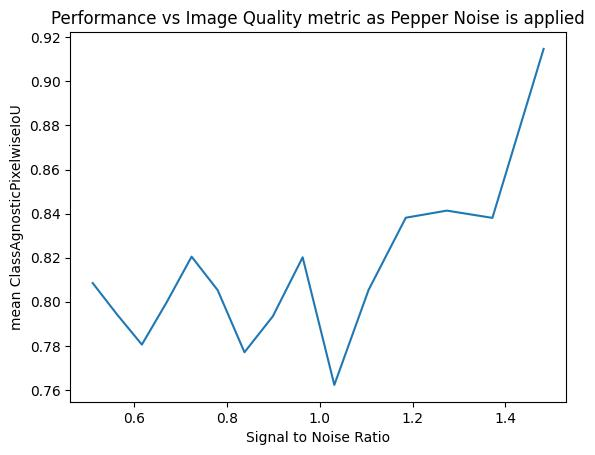

In [6]:
curve, full = generator(
                blackbox_perturber_factories=[noise_perturber_factory],
                blackbox_detector=detector,
                blackbox_scorer=scorer,
                img_batch_size=img_batch_size,
                verbose=True
            )
img_quality_metrics = []
for amount in [i*0.05 for i in range(15)]:
    perturber = PepperNoisePerturber(amount=amount)
    augmentation = JATICDetectionAugmentation(perturber)
    aug_imgs, aug_dets, aug_metadata = augmentation(maite_dataset[0])
    img_quality_metrics.append(img_quality_metric.compute(aug_imgs[0]))

x = [data[0]['amount'] for data in curve]
y = [data[1] for data in curve]

plt.cla()
plt.plot(img_quality_metrics, y)
plt.title('Performance vs Image Quality metric as Pepper Noise is applied')
plt.xlabel('Signal to Noise Ratio')
plt.ylabel('mean ClassAgnosticPixelwiseIoU')


After analysing the performance vs image metric graphs, Jack concludes that when the image metric falls below 1.4, the model performance drops past the acceptable level. He can then advise specific monitoring of the image quality metric that is collected to identify when the model is likely to suffer in quality.